In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import glob
import os
import numpy as np
import sys
sys.path.append( '../src/')
from matplotlib import pyplot as plt
from compile_treeset import compile_folder , compare_treesets


In [2]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff


def graph_treedf(tree_resdf , rescols, rescols_norm , outfolder = '../figures/' , prefix = '' ):
    #sns.violinplot(tree_resdf[rescols] , hue=tree_resdf.filtered, split=True , cut =0 , bw=.15)
    if os.path.exists(outfolder ) == False:
        os.mkdir(outfolder)
    
    
    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols] , cut = 0 , inner= 'box' )
    graph.axhline(max([tree_resdf[col].median() for col in rescols ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    
    
    plt.show()
    plt.savefig( outfolder + prefix + '_score.svg')

    sns.set(rc={'figure.figsize':(10,8)})
    graph = sns.violinplot(tree_resdf[rescols_norm] , cut = 0    )
    graph.axhline(max([tree_resdf[col].median() for col in rescols_norm ]) , dashes = [2 , 1 ] )
    plt.xticks(rotation=45)
    plt.show()
    
    
    plt.savefig( outfolder + prefix + '_norm_score.svg')
    
    clean = tree_resdf[rescols].dropna()
    fig = ff.create_distplot([ clean[col] for col in rescols ], [col for col in rescols] , bin_size = 150, show_rug = True)
    fig.show()
    

In [3]:

def compile_results(cladefolders , plotall = False, scorefunc = 'score'):
    rescols = ['lddt_1_raw_struct_tree' , 'fident_1_raw_struct_tree', 'alntmscore_1_raw_struct_tree', 'sequences' ]
    rescols_norm = ['lddt_1_raw_struct_tree'+'_norm' , 'fident_1_raw_struct_tree'+'_norm', 'alntmscore_1_raw_struct_tree'+'_norm' , 'sequences'+'_norm']

    dfs = []
    plotall = False

    for folder in cladefolders:
        #try:
        if 'logs' not in folder:
            print(folder)
            res = compile_folder(folder, scorefunc = scorefunc, verbose = False)
            if res :
                tree_resdf , refcols = res
                compare_treesets(tree_resdf  , colfilter= 'sequence' , display_lineplot = False , verbose = True)
                tree_resdf['folder'] = folder

                #add filtered bool column
                tree_resdf['filtered'] = tree_resdf['folder'].apply(lambda x : 'unfiltered' in x)

                if 'OMA' in folder:
                    dfs.append(tree_resdf)
                    if plotall == True:
                        graph_treedf(tree_resdf , rescols, rescols_norm)
                else:
                    graph_treedf(tree_resdf , rescols, rescols_norm)

    total_df = pd.concat(dfs)
    try:
        graph_treedf(total_df[total_df.filtered == False] , rescols, rescols_norm , prefix = 'OMA' )
        graph_treedf(total_df[total_df.filtered == True] , rescols, rescols_norm , prefix = 'OMA' )
    except:
        print('graphing err' )
    return total_df

In [ ]:
cladefolders = ['../CATH_data/' , '../CAT_data/']# , '../SCOP_data/' ]
scorefunc = 'score'
cathdf = compile_results(cladefolders, scorefunc = 'root_score'  )

In [ ]:
#todo iterate over hogs and cath and train a model
cladefolders = set(glob.glob( '../OMA_data/*/' ))-set([ '../OMA_data/logs/' ])
cladefolders = cladefolders.union( set(glob.glob( '../OMA_data_unfiltered/OMA_data/*/' )) - set([ '../OMA_data_unfiltered/OMA_data/logs/' ]) )

OMADF = compile_results(cladefolders , scorefunc = 'root_score' )


In [11]:
print(OMADF.filtered.unique(), list(OMADF.columns))


[ True False] ['alntmscore_0_raw_struct_tree', 'alntmscore_0_exp_struct_tree', 'alntmscore_1_exp_struct_tree', 'fident_0_raw_struct_tree', 'lddt_0_exp_struct_tree', 'lddt_1_exp_struct_tree', 'fident_0_exp_struct_tree', 'lddt_1_raw_struct_tree', 'fident_1_raw_struct_tree', 'fident_1_exp_struct_tree', 'alntmscore_1_raw_struct_tree', 'lddt_0_raw_struct_tree', 'sequences', 'nseqs', 'alntmscore_0_raw_struct_tree_norm', 'alntmscore_0_exp_struct_tree_norm', 'alntmscore_1_exp_struct_tree_norm', 'fident_0_raw_struct_tree_norm', 'lddt_0_exp_struct_tree_norm', 'lddt_1_exp_struct_tree_norm', 'fident_0_exp_struct_tree_norm', 'lddt_1_raw_struct_tree_norm', 'fident_1_raw_struct_tree_norm', 'fident_1_exp_struct_tree_norm', 'alntmscore_1_raw_struct_tree_norm', 'lddt_0_raw_struct_tree_norm', 'sequences_norm', 'alntmscore_0_raw_struct_tree_alntmscore_0_exp_struct_tree_delta', 'alntmscore_0_raw_struct_tree_alntmscore_0_exp_struct_tree_max', 'alntmscore_0_raw_struct_tree_alntmscore_0_exp_struct_tree_delta_

In [12]:
import seaborn as sns

filtereddf  = OMADF[OMADF.filtered == True]
unfiltereddf  = OMADF[OMADF.filtered == False]

In [13]:
print(len(filtereddf) , len(unfiltereddf))

1268 3684


1491.4369386934177
94660.0


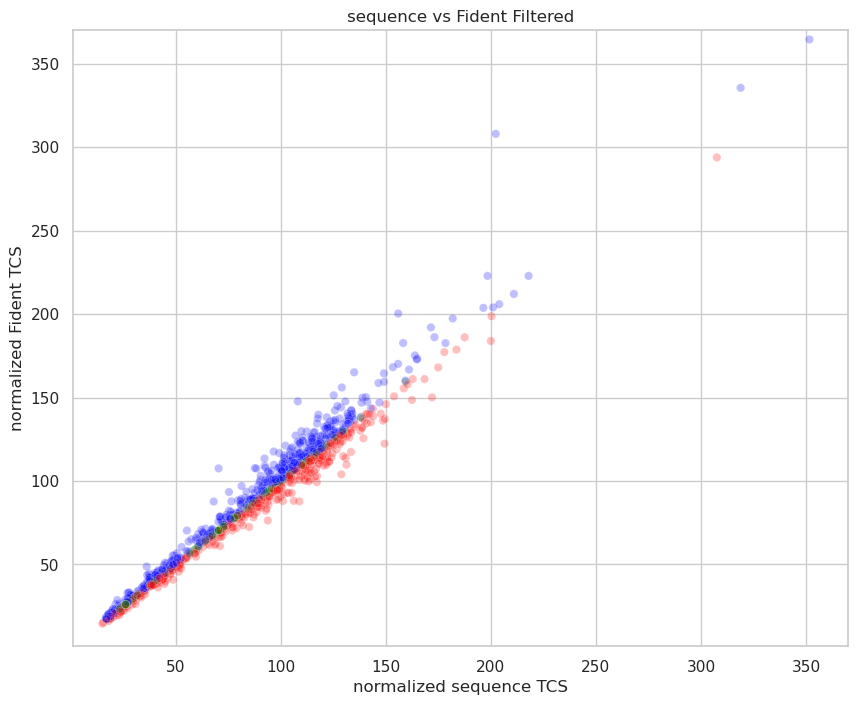

In [213]:
def ret_winner(r, score1 , score2):
    if r[score1] > r[score2]:
        return 'True'
    if r[score1] < r[score2]:
        return 'False'
    if r[score1] == r[score2]:
        return 'Equal'
    
sns.set_style("whitegrid")

palette = { 'True' : 'blue'  , 'False' : 'red' , 'Equal' : 'green'}
markers= {'markers' : {  'True' : 'o'  , 'False' : 'x' , 'Equal' : 'D'}}



filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ('fident_1_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)
ax = sns.scatterplot( data =filtereddf ,  y= 'fident_1_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'  , alpha = .25 , palette=palette , legend = False)
ax.set_title('sequence vs Fident Filtered')
ax.set_ylabel('normalized Fident TCS')
ax.set_xlabel('normalized sequence TCS')

ax.set_ylim(1, 370)
ax.set_xlim(1, 370)


print(np.sum(filtereddf.fident_1_raw_struct_tree_norm - filtereddf.sequences_norm ))
print(np.sum(filtereddf.fident_1_raw_struct_tree - filtereddf.sequences ))
plt.savefig('../figures/sequenceVSFident_filtered.svg')

-6729.161279467089
-125283.0


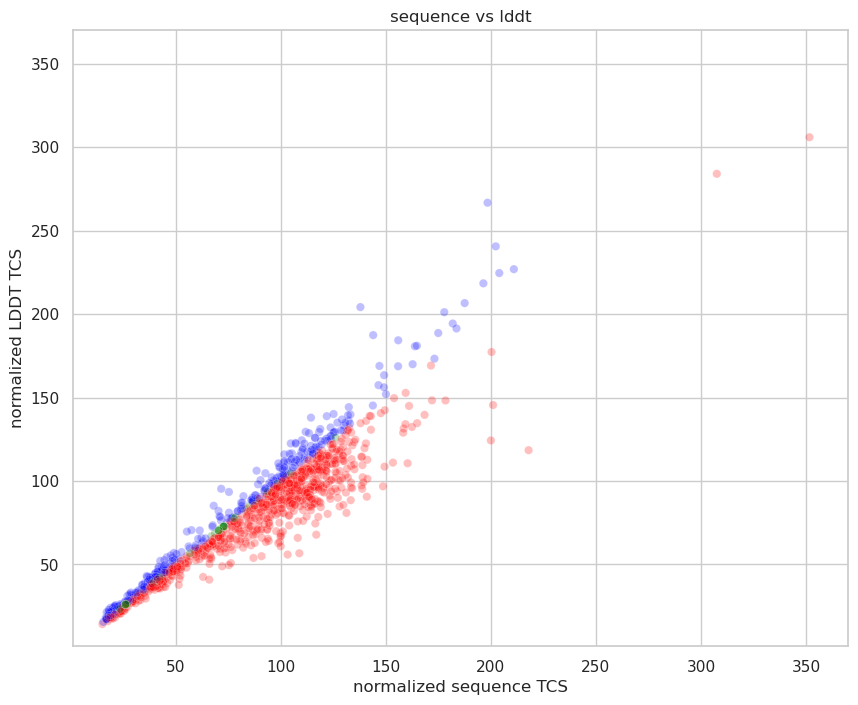

In [214]:
filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ('lddt_0_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)

ax = sns.scatterplot( data =filtereddf ,  y= 'lddt_0_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'   , alpha = .25 , palette=palette , legend=False)
ax.set_title('sequence vs lddt')
print(np.sum(filtereddf.lddt_0_raw_struct_tree_norm - filtereddf.sequences_norm ))
print(np.sum(filtereddf.lddt_0_raw_struct_tree - filtereddf.sequences ))
ax.set_ylim(1, 370)
ax.set_xlim(1, 370)
ax.set_ylabel('normalized LDDT TCS')
ax.set_xlabel('normalized sequence TCS')
plt.savefig('../figures/sequenceVSlddt_filtered.svg')

-15363.620063527585
-2351623.025349914


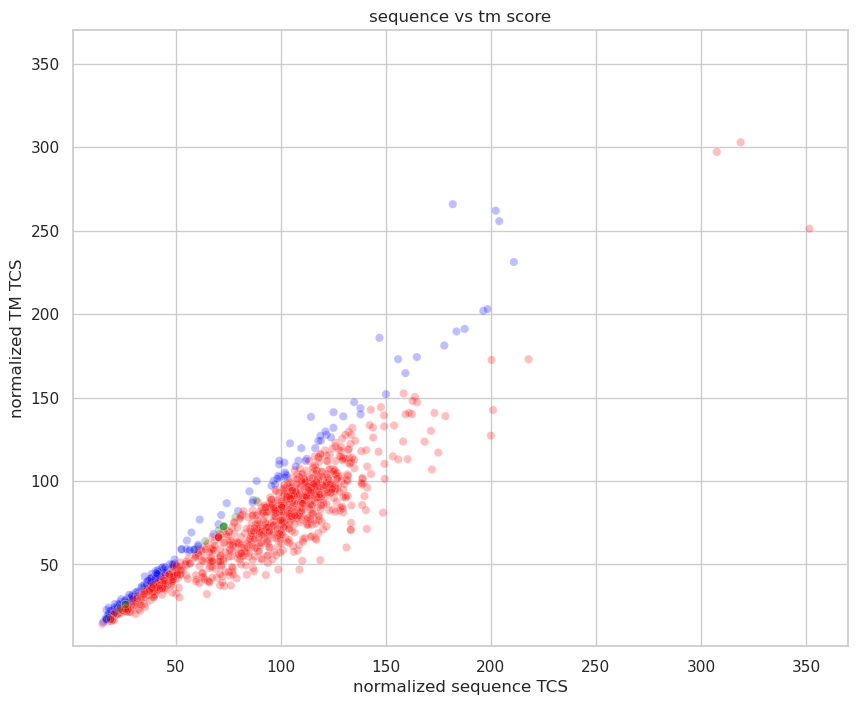

In [215]:
filtereddf['structure better'] = filtereddf.apply( ret_winner , args = ('alntmscore_1_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)
ax = sns.scatterplot( data =filtereddf ,  y= 'alntmscore_1_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'   , alpha = .25 , palette=palette , legend=False)
ax.set_title('sequence vs tm score')

print(np.sum(filtereddf.alntmscore_1_raw_struct_tree_norm - filtereddf.sequences_norm ))
print(np.sum(filtereddf.alntmscore_1_raw_struct_tree_norm - filtereddf.sequences ))

ax.set_ylim(1, 370)
ax.set_xlim(1, 370)
ax.set_ylabel('normalized TM TCS')
ax.set_xlabel('normalized sequence TCS')
plt.savefig('../figures/sequenceVStm_filtered.svg')

3142.1540572937174
98668.0


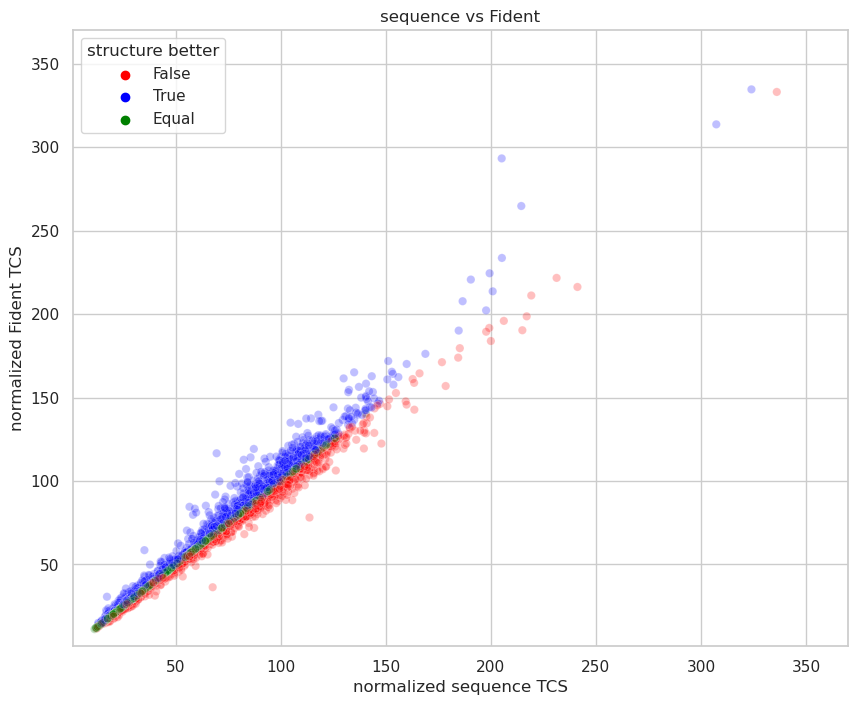

In [216]:
unfiltereddf['structure better'] = unfiltereddf.apply( ret_winner , args = ('fident_1_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)
ax = sns.scatterplot( data =unfiltereddf ,  y= 'fident_1_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'  , alpha = .25 , palette=palette)
ax.set_title('sequence vs Fident')

#ax = sns.scatterplot( y=unfiltereddf.fident_1_raw_struct_tree_norm , x=unfiltereddf.sequences_norm , alpha = .15 )
print(np.sum(unfiltereddf.fident_1_raw_struct_tree_norm - unfiltereddf.sequences_norm ))
print(np.sum(unfiltereddf.fident_1_raw_struct_tree - unfiltereddf.sequences ))

ax.set_ylim(1, 370)
ax.set_xlim(1, 370)
ax.set_ylabel('normalized Fident TCS')
ax.set_xlabel('normalized sequence TCS')
plt.savefig('../figures/sequenceVSfident_unfiltered.svg')

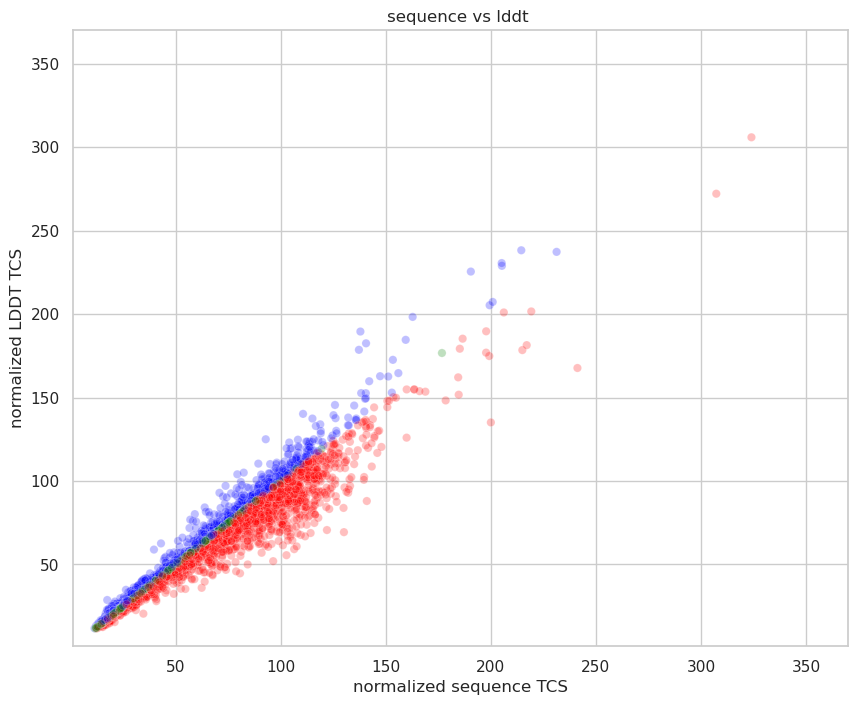

In [217]:
unfiltereddf['structure better'] = unfiltereddf.apply( ret_winner , args = ('lddt_1_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)

ax = sns.scatterplot( data =unfiltereddf ,  y= 'lddt_1_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'  , alpha = .25 , palette=palette , legend=False)
ax.set_title('sequence vs lddt ')
ax.set_ylim(1, 370)
ax.set_xlim(1, 370)
ax.set_ylabel('normalized LDDT TCS')
ax.set_xlabel('normalized sequence TCS')
plt.savefig('../figures/sequenceVSlddt_unfiltered.svg')

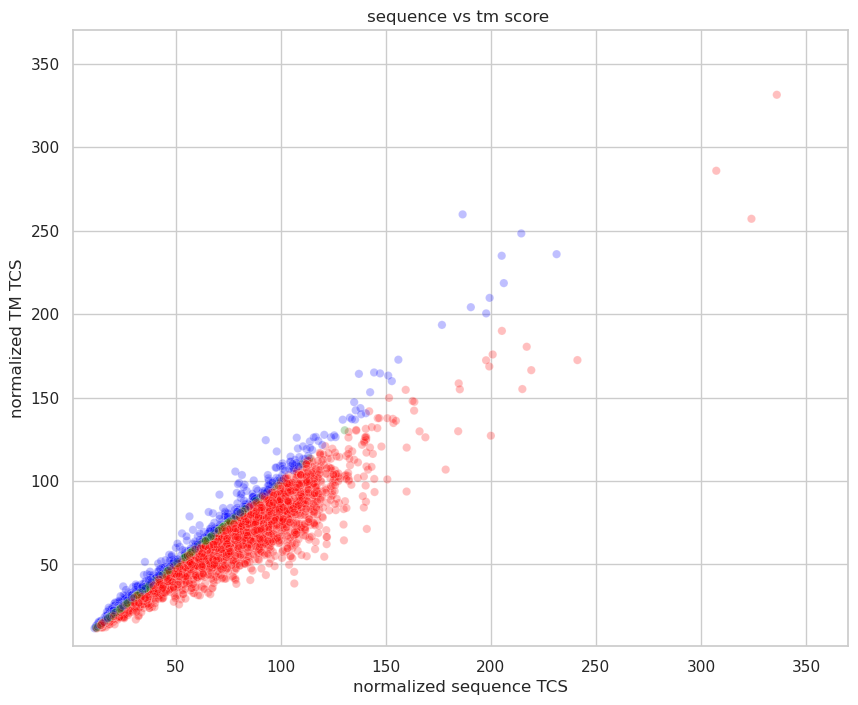

In [218]:
unfiltereddf['structure better'] = unfiltereddf.apply( ret_winner , args = ('alntmscore_1_raw_struct_tree_norm'  , 'sequences_norm' ) , axis = 1)
ax = sns.scatterplot( data =unfiltereddf ,  y= 'alntmscore_1_raw_struct_tree_norm' , x='sequences_norm' , hue = 'structure better'   , alpha = .25 , palette=palette , legend=False)
ax.set_title('sequence vs tm score ')
ax.set_ylim(1, 370)
ax.set_xlim(1, 370)
ax.set_ylabel('normalized TM TCS')
ax.set_xlabel('normalized sequence TCS')
plt.savefig('../figures/sequenceVStm_unfiltered.svg')

In [219]:
#root score relfects the performance deeper in the tree



In [198]:
#plt the OMA clades w and without filtering 
#plot the cat and cath and total oma with and without filtering


In [201]:
#construct structure and sequence feature dataset
import tqdm

def ret_description(vec , label = ''):
    return { label+'_mean': np.mean(vec) , label+'_max': np.amax(vec) , label+'_min': np.amin(vec) ,label+'_var': np.var(vec) }

cladefolders = set(glob.glob( '../OMA_data/*/' ))-set([ '../OMA_data/logs/' ])
cladefolders = cladefolders.union( set(glob.glob( '../OMA_data_unfiltered/OMA_data/*/' )) - set([ '../OMA_data_unfiltered/OMA_data/logs/' ]) )
allfolders = cladefolders

dfs = []
print(allfolders)
for clade in allfolders:
    print(clade)
    res = {}
    folders = glob.glob(clade + '*/' )
    for folder in tqdm.tqdm_notebook(folders):
        if 'logs' not in folder:
            
            nstructs = len(glob.glob(folder+'structs/*.pdb'))
            try:
                with open(folder + 'sequences.fst') as fstin:
                    nseqs = fstin.read().count('>')
            except:
                nseqs = 0
            if nstructs == nseqs:
                if os.path.isfile(folder + 'plddt.json' ):
                    plddt_df = pd.read_json(folder + 'plddt.json').T
                    if len(plddt_df)>0:
                        plddt_df.columns = 'nobs,minmax,mean,variance,skewness,kurtosis'.split(',')
                        plddt_df['min'] = plddt_df.minmax.map( lambda r: r[0] )
                        plddt_df['max'] = plddt_df.minmax.map( lambda r: r[1] )
                        res[folder] = {}
                        for col in ['nobs', 'min' , 'max' , 'mean' , 'variance' , 'skewness' , 'kurtosis' ]:
                            descriptors = ret_description(plddt_df[col] , label = col)
                            for l in descriptors:
                                res[folder][l] = descriptors[l]
                        #add in some descriptors of the taxonomic spread and sequence set
                        seqdf = pd.read_csv(folder+'sequence_dataset.csv' )
                        res[folder]['nprots'] = len(seqdf)
                        cladesets = [ set(l.split(',')) for l in  seqdf['Taxonomic lineage (Ids)'] ]
                        union_all = cladesets[0]
                        intersection_all = cladesets[0]
                        for c in cladesets:
                            union_all = union_all.union(c)
                            intersection_all.intersection(c)
                        res[folder]['n_clades'] = len(union_all)
                        res[folder]['inter_clades'] = len(intersection_all)
                        res[folder]['inter/nc'] =  res[folder]['inter_clades'] /  res[folder]['n_clades'] 
                        res[folder]['nc/np'] = res[folder]['nprots'] / res[folder]['n_clades']
        
    resdf = pd.DataFrame.from_dict(res, orient = 'index')
    dfs.append(resdf)
seqset_resdf = pd.concat(dfs)



{'../OMA_data_unfiltered/OMA_data/Bilateria/', '../OMA_data/Tetrapoda/', '../OMA_data_unfiltered/OMA_data/Dikarya/', '../OMA_data/Eumetazoa/', '../OMA_data_unfiltered/OMA_data/Opisthokonta/', '../OMA_data/Chordata/', '../OMA_data/Opisthokonta/', '../OMA_data/Bacteria/', '../OMA_data/Dikarya/', '../OMA_data/LUCA/', '../OMA_data/Euteleostomi/', '../OMA_data_unfiltered/OMA_data/Euteleostomi/', '../OMA_data/Eukaryota/', '../OMA_data_unfiltered/OMA_data/Bacteria/', '../OMA_data_unfiltered/OMA_data/Eukaryota/', '../OMA_data_unfiltered/OMA_data/LUCA/', '../OMA_data/Bilateria/', '../OMA_data/Fungi/', '../OMA_data_unfiltered/OMA_data/Fungi/', '../OMA_data_unfiltered/OMA_data/Tetrapoda/', '../OMA_data_unfiltered/OMA_data/Chordata/', '../OMA_data_unfiltered/OMA_data/Eumetazoa/'}
../OMA_data_unfiltered/OMA_data/Bilateria/


/tmp/29494970/ipykernel_2668411/1136481107.py:17: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data/Tetrapoda/


  0%|          | 0/360 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Dikarya/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data/Eumetazoa/


  0%|          | 0/897 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Opisthokonta/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data/Chordata/


  0%|          | 0/787 [00:00<?, ?it/s]

../OMA_data/Opisthokonta/


  0%|          | 0/524 [00:00<?, ?it/s]

../OMA_data/Bacteria/


  0%|          | 0/634 [00:00<?, ?it/s]

../OMA_data/Dikarya/


  0%|          | 0/187 [00:00<?, ?it/s]

../OMA_data/LUCA/


  0%|          | 0/881 [00:00<?, ?it/s]

../OMA_data/Euteleostomi/


  0%|          | 0/1020 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Euteleostomi/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data/Eukaryota/


  0%|          | 0/606 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Bacteria/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Eukaryota/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/LUCA/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data/Bilateria/


  0%|          | 0/559 [00:00<?, ?it/s]

../OMA_data/Fungi/


  0%|          | 0/139 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Fungi/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Tetrapoda/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Chordata/


  0%|          | 0/118 [00:00<?, ?it/s]

../OMA_data_unfiltered/OMA_data/Eumetazoa/


  0%|          | 0/118 [00:00<?, ?it/s]

In [202]:
print(seqset_resdf)
seqset_resdf.to_csv('structure_and_sequence_qcmetrics.csv')

                                nobs_mean  nobs_max  nobs_min      nobs_var  \
../OMA_data/Bacteria/HOG33/    818.222222       985       642  11731.061728   
../OMA_data/Bacteria/HOG59/    499.307692       533       447    473.443787   
../OMA_data/Bacteria/HOG123/   399.333333       516       277   1311.984127   
../OMA_data/Bacteria/HOG185/    64.357143        71        56     29.086735   
../OMA_data/Bacteria/HOG20/    203.357143       214       191     51.372449   
...                                   ...       ...       ...           ...   
../OMA_data/Bilateria/HOG11/   413.486486       442       281    631.952520   
../OMA_data/Bilateria/HOG34/   582.684211       672       431   2526.268698   
../OMA_data/Bilateria/HOG666/  262.608696       295       182    347.325142   
../OMA_data/Bilateria/HOG893/  216.000000       235       193     81.441860   
../OMA_data/Bilateria/HOG646/  147.962025       178       129     56.163115   

                                min_mean  min_max  

In [203]:
#add to the tree comparison data
tree_resdf = unfiltereddf.merge( seqset_resdf , left_index = True, right_index = True, how = 'inner' )
print(tree_resdf)

                               alntmscore_0_raw_struct_tree  \
../OMA_data/Bacteria/HOG155/                          256.0   
../OMA_data/Bacteria/HOG325/                          233.0   
../OMA_data/Bacteria/HOG437/                          150.0   
../OMA_data/Bacteria/HOG33/                           198.0   
../OMA_data/Bacteria/HOG385/                          298.0   
...                                                     ...   
../OMA_data/Bilateria/HOG34/                         3880.0   
../OMA_data/Bilateria/HOG9/                          5299.0   
../OMA_data/Bilateria/HOG646/                       13121.0   
../OMA_data/Bilateria/HOG666/                        5329.0   
../OMA_data/Bilateria/HOG679/                       15367.0   

                               alntmscore_0_exp_struct_tree  \
../OMA_data/Bacteria/HOG155/                          256.0   
../OMA_data/Bacteria/HOG325/                          233.0   
../OMA_data/Bacteria/HOG437/                          

In [204]:
print(tree_resdf.columns)

Index(['alntmscore_0_raw_struct_tree', 'alntmscore_0_exp_struct_tree',
       'alntmscore_1_exp_struct_tree', 'fident_0_raw_struct_tree',
       'lddt_0_exp_struct_tree', 'lddt_1_exp_struct_tree',
       'fident_0_exp_struct_tree', 'lddt_1_raw_struct_tree',
       'fident_1_raw_struct_tree', 'fident_1_exp_struct_tree',
       ...
       'skewness_var', 'kurtosis_mean', 'kurtosis_max', 'kurtosis_min',
       'kurtosis_var', 'nprots', 'n_clades', 'inter_clades', 'inter/nc',
       'nc/np'],
      dtype='object', length=389)


In [205]:
#try to predict the delta using these features w gradient boosted trees
#try to predict the RF distance as well

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [210]:
#'nc/np'

feature_names = ['nobs_mean', 'nobs_max',
       'nobs_min', 'nobs_var', 'min_mean', 'min_max', 'min_min', 'min_var',
       'max_mean', 'max_max', 'max_min', 'max_var', 'mean_mean', 'mean_max',
       'mean_min', 'mean_var', 'variance_mean', 'variance_max', 'variance_min',
       'variance_var', 'skewness_mean', 'skewness_max', 'skewness_min',
       'skewness_var', 'kurtosis_mean', 'kurtosis_max', 'kurtosis_min',
       'kurtosis_var', 'nprots', 'n_clades', 'inter_clades', 'inter/nc','nc/np'
       ]
X, y = tree_resdf[feature_names], tree_resdf.fident_1_raw_struct_tree_norm - tree_resdf.sequences_norm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)


params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

The mean squared error (MSE) on test set: 3.5802


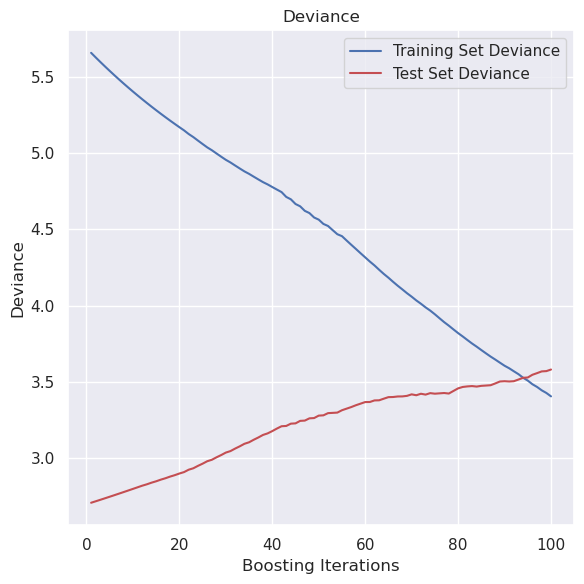

In [211]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

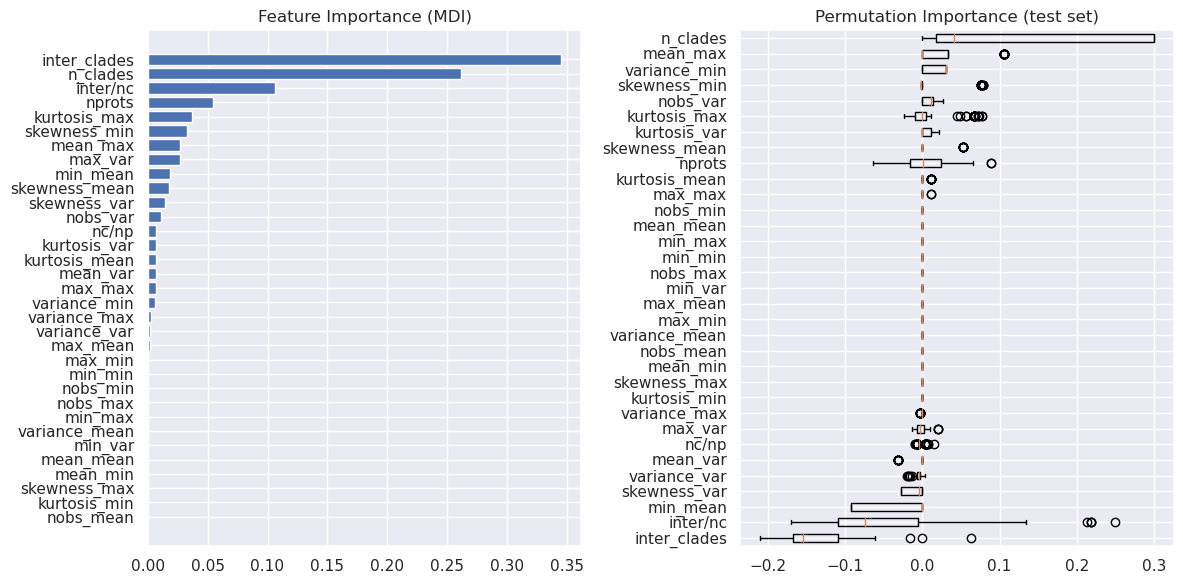

In [212]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()